In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.etoile_achat import graphe_etoile_achat

DATA_PATH = "../donnees/ecommerce/"

In [ ]:
dot_achats = graphe_etoile_achat()
dot_achats

In [ ]:
# 1) Lecture des tables de base
orders    = pd.read_parquet(DATA_PATH + "orders.parquet")
items     = pd.read_parquet(DATA_PATH + "items.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")
sellers   = pd.read_parquet(DATA_PATH + "sellers.parquet")
products  = pd.read_parquet(DATA_PATH + "products.parquet")
geo       = pd.read_parquet(DATA_PATH + "geolocation.parquet")

print("Shapes brutes :")
print("orders   :", orders.shape)
print("items    :", items.shape)
print("customers:", customers.shape)
print("sellers  :", sellers.shape)
print("products :", products.shape)
print("geo      :", geo.shape)


# 2) Préparation ligne d'achat
items_fact_cols = [
    "order_id",
    "order_item_id",
    "product_id",
    "seller_id",
    "price",
    "freight_value",
    "shipping_limit",   # datetime
]
items_fact = items[items_fact_cols].copy()


# 3 préparation des infos commande (clé client, statut, timestamp)
status_col = None
if "order_status" in orders.columns:
    status_col = "order_status"
elif "status" in orders.columns:
    status_col = "status"

orders_fact_cols = ["order_id", "customer_id", "purchase_timestamp"]
if status_col is not None:
    orders_fact_cols.append(status_col)

orders_fact = orders[orders_fact_cols].copy()

# Si la colonne s'appelle 'status', on la renomme en 'order_status'
if "status" in orders_fact.columns and "order_status" not in orders_fact.columns:
    orders_fact = orders_fact.rename(columns={"status": "order_status"})


# 4) Préparation des infos client
cust_fact = customers[["customer_id", "zip_code"]].copy()


# 5) Construction de la table de faits F_ACHATS
F_ACHATS = (
    items_fact
    .merge(orders_fact, on="order_id", how="left")
    .merge(cust_fact,   on="customer_id", how="left")
)

# 5.a) Calcul des métriques de ligne
F_ACHATS["line_revenue"] = F_ACHATS["price"]
F_ACHATS["line_total"]   = F_ACHATS["price"] + F_ACHATS["freight_value"]

# 5.b) Recalcule propre de la durée "limit" (h) = shipping_limit - purchase_timestamp
delta_limit = F_ACHATS["shipping_limit"] - F_ACHATS["purchase_timestamp"]
F_ACHATS["limit"] = delta_limit.dt.total_seconds() / 3600.0

F_ACHATS = F_ACHATS.drop(columns=["shipping_limit"])


# 6) Réorganisation des colonnes suivant le schéma de l'étoile 2
cols_schema = [
    "order_item_id",
    "order_id",
    "product_id",
    "seller_id",
    "customer_id",
    "zip_code",
    "purchase_timestamp",
    "order_status",     # maintenant présent même si la colonne d'origine s'appelait 'status'
    "price",
    "freight_value",
    "line_revenue",
    "line_total",
    "limit",            # (h) shipping_limit - purchase_timestamp
]

final_cols = [c for c in cols_schema if c in F_ACHATS.columns]
F_ACHATS = F_ACHATS[final_cols]


# 7) Contrôle rapide du résultat
print("F_ACHATS shape :", F_ACHATS.shape)
print("Colonnes (", len(F_ACHATS.columns), "):")
print(list(F_ACHATS.columns))

display(F_ACHATS.head(5))


# 8) Sauvegarde
OUTPUT_PATH = "f_achats.parquet"  # adapte si besoin
F_ACHATS.to_parquet(OUTPUT_PATH, index=False)
print(f"F_ACHATS sauvegardé dans : {OUTPUT_PATH}")


In [ ]:
# Analyse 1  Saisonnalité des achats & mix produits / clients
# Dans cette première analyse sur l’étoile 2, on veut comprendre comment évoluent
# les achats au niveau ligne de commande (line_total) dans le temps (année, mois, jour)
# et comment cette valeur se répartit entre les catégories de produits et les profils
# de clients (régions, états, villes). On part donc du line_total global, puis on
# descend dans les hiérarchies de temps, de produit et de géographie pour identifier
# les saisons fortes, les segments produits dominants et les zones clients clés.

In [ ]:
# Hypothèse 1
# On suppose qu’une part importante du line_total est concentrée sur un petit nombre
# de segments : quelques catégories de produits, livrées à des clients situés dans
# les grandes régions économiques et pendant des périodes de pic. Ces segments ont
# en moyenne des paniers plus élevés et un poids de freight_value plus important,
# ce qui les rend plus sensibles aux contraintes logistiques et donc aux risques
# d’insatisfaction observés dans l’étoile 1.

In [30]:
# 0 Dimensions de temps de base

# Préparation
F_ACHATS["year"]  = F_ACHATS["purchase_timestamp"].dt.year
F_ACHATS["month"] = F_ACHATS["purchase_timestamp"].dt.month
F_ACHATS["date"]  = F_ACHATS["purchase_timestamp"].dt.normalize()

# Semaine ISO, jour de semaine, heure
F_ACHATS["week"]   = F_ACHATS["purchase_timestamp"].dt.isocalendar().week
F_ACHATS["weekday"] = F_ACHATS["purchase_timestamp"].dt.weekday      # 0 = lundi, 6 = dimanche
F_ACHATS["hour"]    = F_ACHATS["purchase_timestamp"].dt.hour

# Affichage
print("Colonnes temps ajoutées : year, month, date, week, weekday, hour")
display(
    F_ACHATS[["purchase_timestamp", "year", "month", "date", "week", "weekday", "hour"]]
    .head()
)


Colonnes temps ajoutées : year, month, date, week, weekday, hour


,purchase_timestamp,year,month,date,week,weekday,hour
0,2017-09-13 08:59:02,2017,9,2017-09-13,37,2,8
1,2017-04-26 10:53:06,2017,4,2017-04-26,17,2,10
2,2018-01-14 14:33:31,2018,1,2018-01-14,2,6,14
3,2018-08-08 10:00:35,2018,8,2018-08-08,32,2,10
4,2017-02-04 13:57:51,2017,2,2017-02-04,5,5,13


== 1) Agrégation annuelle du line_total ==


,year,line_total_sum,line_total_mean,n_lines
0,2016,57183.21,154.549216,370
1,2017,7142672.43,140.426872,50864
2,2018,8643697.60,140.740159,61416


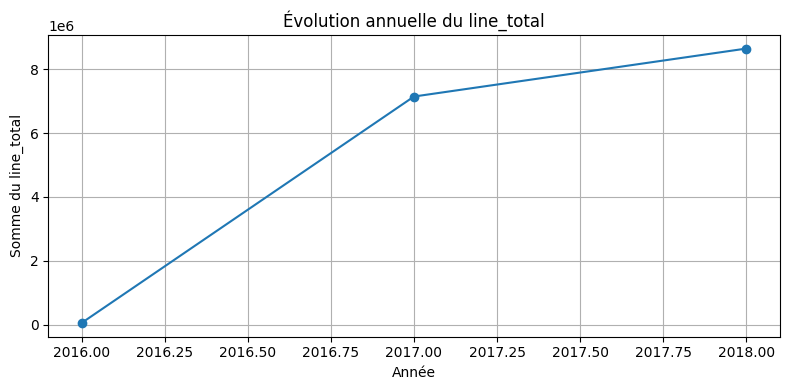

In [31]:
# 1) Évolution annuelle du line_total

# Préparation
annual = (
    F_ACHATS
    .groupby("year", as_index=False)
    .agg(
        line_total_sum=("line_total", "sum"),
        line_total_mean=("line_total", "mean"),
        n_lines=("order_item_id", "count")
    )
    .sort_values("year")
)

print("== 1) Agrégation annuelle du line_total ==")
display(annual)

# Affichage
plt.figure(figsize=(8, 4))
plt.plot(annual["year"], annual["line_total_sum"], marker="o")
plt.title("Évolution annuelle du line_total")
plt.xlabel("Année")
plt.ylabel("Somme du line_total")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# On observe une très forte hausse du line_total entre 2016 et 2017, puis une croissance plus modérée en 2018.
# L’année 2016 pèse très peu dans le total : peu de lignes (370) et sans doute une couverture partielle de la période.
# Le panier moyen par ligne (line_total_mean) reste assez stable autour de 140–150 R$, ce n’est donc pas lui qui explique la croissance.
# L’augmentation du chiffre d’affaires provient surtout de la hausse du nombre de lignes (de 370 à plus de 60 000).
# On peut en déduire une montée en puissance rapide de la plateforme entre 2016 et 2018.
# Pour tester notre hypothèse, il faudra vérifier si cette croissance globale se concentre sur quelques segments produits / régions.


== 2) Pivot line_total (année x mois) (NaN → 0) ==
month          1          2           3           4           5           6   \
year                                                                           
2016         0.00       0.00        0.00        0.00        0.00        0.00   
2017    137188.49  286280.62   432048.59   412422.24   586190.95   502963.04   
2018   1107301.89  986908.96  1155126.82  1159698.04  1149781.82  1022677.11   

month          7           8          9          10          11         12  
year                                                                        
2016         0.00        0.00     354.75   56808.84        0.00      19.62  
2017    584971.62   668204.60  720398.91  769312.37  1179143.77  863547.23  
2018   1058728.03  1003308.47     166.46       0.00        0.00       0.00  


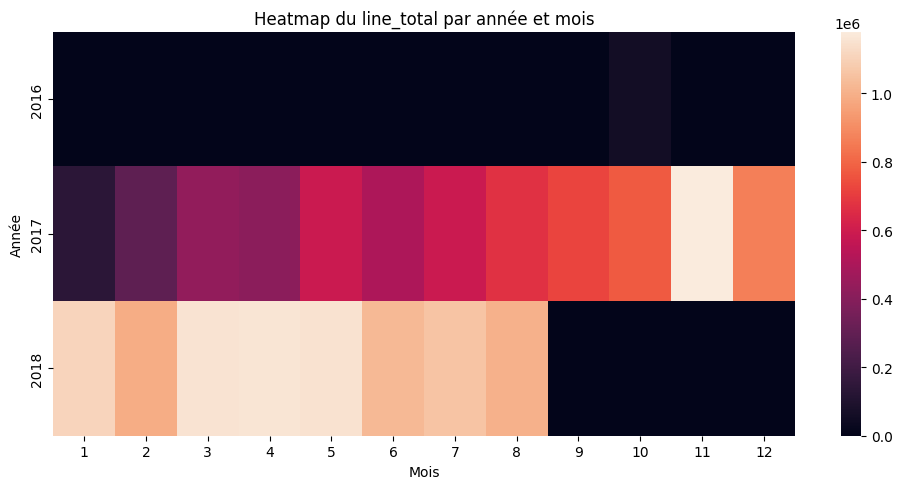

In [33]:
# 2) Saisonnalité mensuelle du line_total par année (heatmap)

# Préparation
monthly = (
    F_ACHATS
    .groupby(["year", "month"], as_index=False)
    .agg(line_total_sum=("line_total", "sum"))
)

# On s'assure que les années sont triées
monthly = monthly.sort_values(["year", "month"])

# Construction d'une grille complète année x mois (1 à 12)
years  = monthly["year"].unique()
months = np.arange(1, 13)

full_index = pd.MultiIndex.from_product(
    [years, months],
    names=["year", "month"]
)

monthly_full = (
    monthly
    .set_index(["year", "month"])
    .reindex(full_index)
    .reset_index()
)

pivot_monthly = monthly_full.pivot(index="year", columns="month", values="line_total_sum")

# Ici, on remplace les NaN par 0 pour les mois sans ventes
pivot_monthly = pivot_monthly.fillna(0)

print("== 2) Pivot line_total (année x mois) (NaN → 0) ==")
print(pivot_monthly)

# Affichage
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_monthly, annot=False)
plt.title("Heatmap du line_total par année et mois")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()


In [34]:
# La heatmap confirme que 2016 ne couvre que la fin d’année : quasiment aucun mois actif, sauf un pic en octobre.
# En 2017, le line_total progresse mois après mois, avec un vrai pic sur la fin d’année, surtout en novembre.
# En 2018, les niveaux mensuels sont déjà très élevés dès janvier et restent forts jusqu’en août, au-dessus de 2017.
# Le retour à zéro à partir de septembre 2018 correspond à la fin de la période d’observation, pas à un effondrement des ventes.
# Globalement, la saisonnalité est marquée par une montée progressive vers la fin 2017 puis un haut plateau sur le premier semestre 2018.
# Ces périodes de pic (fin 2017, début 2018) seront à cibler pour voir si la croissance vient bien de quelques segments produits / régions.


== 3) Top 10 catégories par line_total (catégories non NaN) ==


,category_name,line_total_sum
43,health_beauty,1441248.07
73,watches_gifts,1305541.61
7,bed_bath_table,1241681.72
68,sports_leisure,1156656.48
15,computers_accessories,1059272.40
39,furniture_decor,902511.79
49,housewares,778397.77
20,cool_stuff,719329.95
5,auto,685384.32
42,garden_tools,584219.21


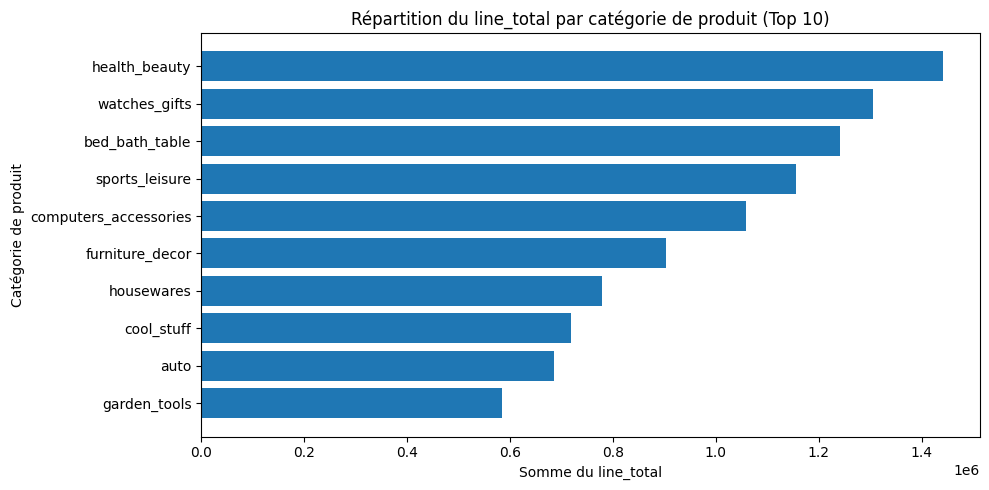

In [35]:
# 3) Répartition du line_total par catégorie de produit (top catégories)

# Préparation
prod_dim = products[["product_id", "category_name"]].copy()

f_achats_prod = F_ACHATS.merge(prod_dim, on="product_id", how="left")

# On enlève les lignes sans catégorie pour la répartition
f_achats_prod = f_achats_prod.dropna(subset=["category_name"])

cat_totals = (
    f_achats_prod
    .groupby("category_name", as_index=False)
    .agg(line_total_sum=("line_total", "sum"))
    .sort_values("line_total_sum", ascending=False)
)

top_n = 10
top_cat = cat_totals.head(top_n)

print(f"== 3) Top {top_n} catégories par line_total (catégories non NaN) ==")
display(top_cat)

# Affichage
plt.figure(figsize=(10, 5))
plt.barh(top_cat["category_name"], top_cat["line_total_sum"])
plt.title(f"Répartition du line_total par catégorie de produit (Top {top_n})")
plt.xlabel("Somme du line_total")
plt.ylabel("Catégorie de produit")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [36]:
# Ce graphique montre que le line_total est très concentré sur quelques catégories, en particulier health_beauty et watches_gifts.
# Les 10 premières catégories cumulent une part importante du chiffre d’affaires au niveau ligne, ce qui confirme un mix produit dominé par quelques segments.
# On retrouve plusieurs catégories liées à la maison (bed_bath_table, furniture_decor, housewares, garden_tools) qui, ensemble, représentent un volume significatif.
# Les segments plus “plaisir” ou cadeaux (watches_gifts, cool_stuff, sports_leisure) pèsent aussi lourd, ce qui laisse penser à des achats saisonniers ou événementiels.
# La forte concentration sur ces familles suggère que les contraintes logistiques et les risques d’insatisfaction se joueront surtout sur ces types de produits.
# Pour tester l’hypothèse, il faudra vérifier si ces catégories dominantes sont bien celles qui montent le plus durant les périodes de pic et dans quelles zones clients.


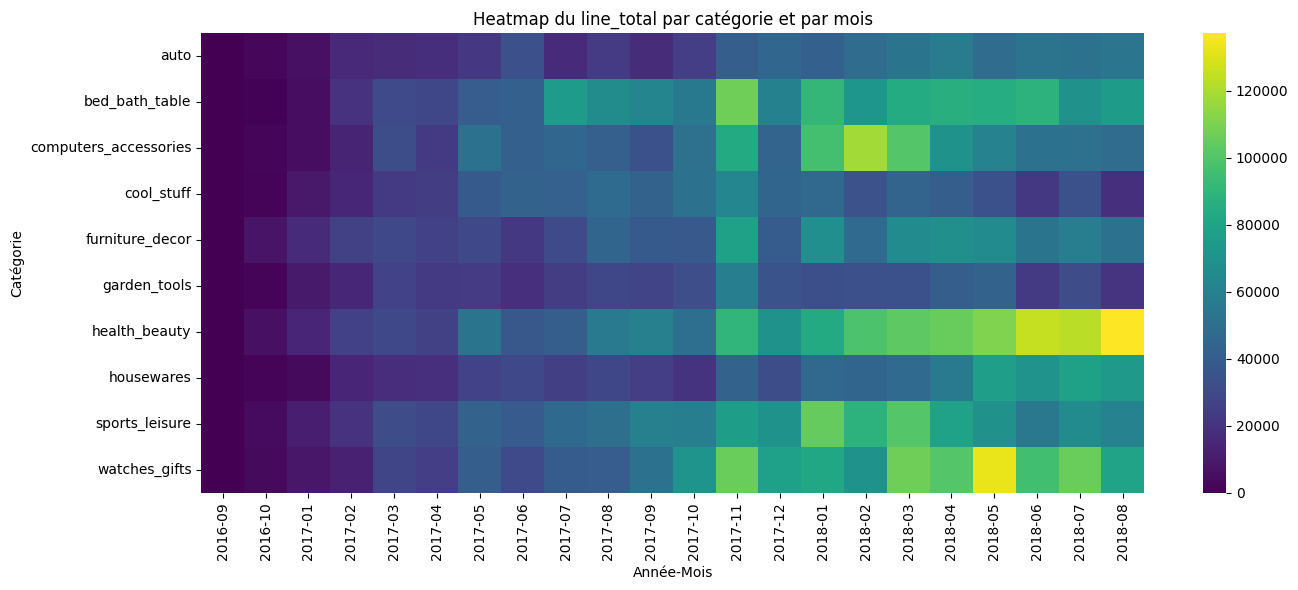

In [37]:
# 4 Heatmap Catégorie × Année-Mois

# Préparation
monthly_cat2 = monthly_cat.copy()
monthly_cat2["annee_mois"] = (
    monthly_cat2["year"].astype(str) + "-" + monthly_cat2["month"].astype(str).str.zfill(2)
)

pivot_cat_month = monthly_cat2.pivot(
    index="category_name", columns="annee_mois", values="line_total_sum"
).fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_cat_month, cmap="viridis")
plt.title("Heatmap du line_total par catégorie et par mois")
plt.xlabel("Année-Mois")
plt.ylabel("Catégorie")
plt.tight_layout()
plt.show()


In [38]:
# La heatmap met en évidence une montée progressive du line_total sur l’ensemble des catégories entre 2017 et le premier semestre 2018.
# Quelques segments ressortent nettement, notamment health_beauty, watches_gifts et sports_leisure, qui concentrent les plus fortes intensités dans les mois de pic.
# Ces catégories affichent des pics récurrents en fin 2017 puis début 2018, ce qui confirme une saisonnalité forte et un effet “événements / fêtes”.
# D’autres segments comme computers_accessories ou auto montent aussi mais de façon moins marquée, ce qui renforce l’idée d’un mix produit très concentré.
# Le contraste entre les catégories dominantes et celles plus faibles suggère que la croissance globale observée précédemment repose surtout sur quelques familles clés.
# Cela va dans le sens de l’hypothèse : les pics de ventes viennent principalement d’un petit nombre de segments, possiblement plus sensibles aux contraintes logistiques.
# On observe enfin que quasiment toutes les catégories s’activent simultanément lors des périodes de pic, mais les volumes restent très inégaux selon les segments.


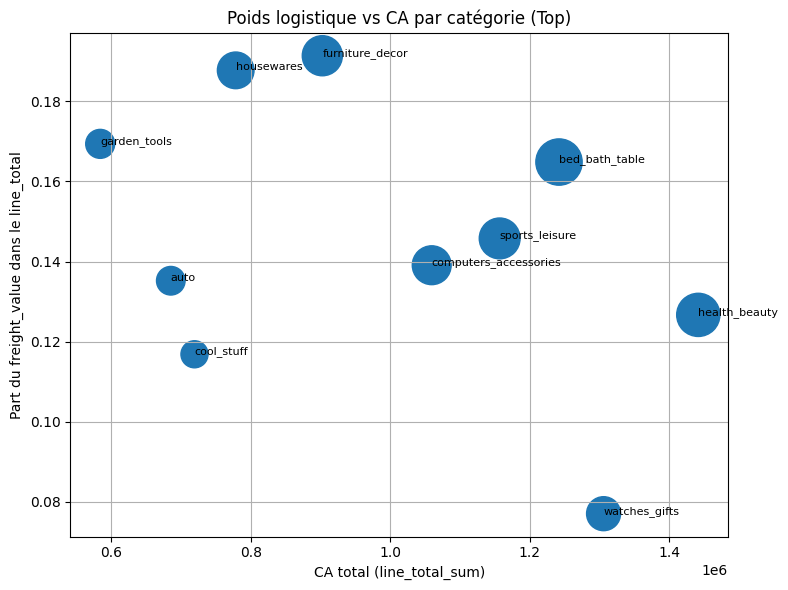

In [40]:
# 5) Part du freight_value dans le line_total par catégorie de produit

cat_freight2 = (
    f_achats_prod
    .groupby("category_name", as_index=False)
    .agg(
        freight_sum=("freight_value", "sum"),
        line_total_sum=("line_total", "sum"),
        n_lines=("order_item_id", "count")
    )
)

cat_freight2["freight_share"] = np.where(
    cat_freight2["line_total_sum"] > 0,
    cat_freight2["freight_sum"] / cat_freight2["line_total_sum"],
    np.nan
)

# afficahge
cat_scatter = cat_freight2[cat_freight2["category_name"].isin(top_cat_list)].copy()

plt.figure(figsize=(8, 6))
plt.scatter(
    cat_scatter["line_total_sum"],
    cat_scatter["freight_share"],
    s=cat_scatter["n_lines"] / 10  # à ajuster
)
for _, row in cat_scatter.iterrows():
    plt.text(row["line_total_sum"], row["freight_share"], row["category_name"], fontsize=8)

plt.xlabel("CA total (line_total_sum)")
plt.ylabel("Part du freight_value dans le line_total")
plt.title("Poids logistique vs CA par catégorie (Top)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Ce graphique montre que les catégories qui génèrent le plus de CA, comme health_beauty ou watches_gifts,
# ne sont pas forcément celles où le poids du freight est le plus élevé. Elles vendent beaucoup,
# mais leur logistique reste relativement “légère”. À l’inverse, des catégories moins rentables comme
# furniture_decor ou housewares ont une part logistique beaucoup plus forte, probablement à cause
# de produits plus lourds ou encombrants. On voit aussi que certaines catégories intermédiaires,
# comme bed_bath_table ou sports_leisure, combinent volumes importants et coût logistique non négligeable.
# Cela suggère que la croissance observée se fait surtout sur des segments assez faciles à livrer,
# tandis que d’autres restent plus sensibles aux contraintes logistiques, ce qui rejoint notre hypothèse.


== 6a) line_total par macro-région client ==


,macro_region,line_total_sum
3,Sudeste,10232323.50
4,Sul,2296975.80
1,Nordeste,1880799.54
0,Centro-Oeste,1023062.00
2,Norte,410392.40


== 6b) Top 10 états clients par line_total ==


,macro_region,name_state,line_total_sum
23,Sudeste,São Paulo,5921678.12
22,Sudeste,Rio de Janeiro,2129681.98
21,Sudeste,Minas Gerais,1856161.49
25,Sul,Rio Grande do Sul,885826.76
24,Sul,Paraná,800935.44
5,Nordeste,Bahia,611506.67
26,Sul,Santa Catarina,610213.60
0,Centro-Oeste,District fédéral,353229.44
1,Centro-Oeste,Goiás,347706.93
20,Sudeste,Espírito Santo,324801.91


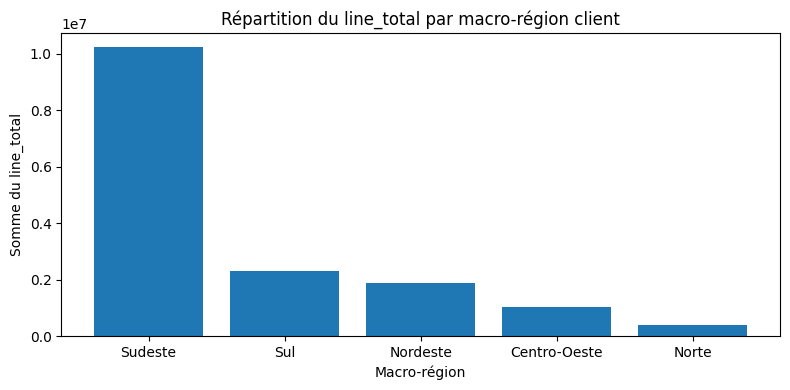

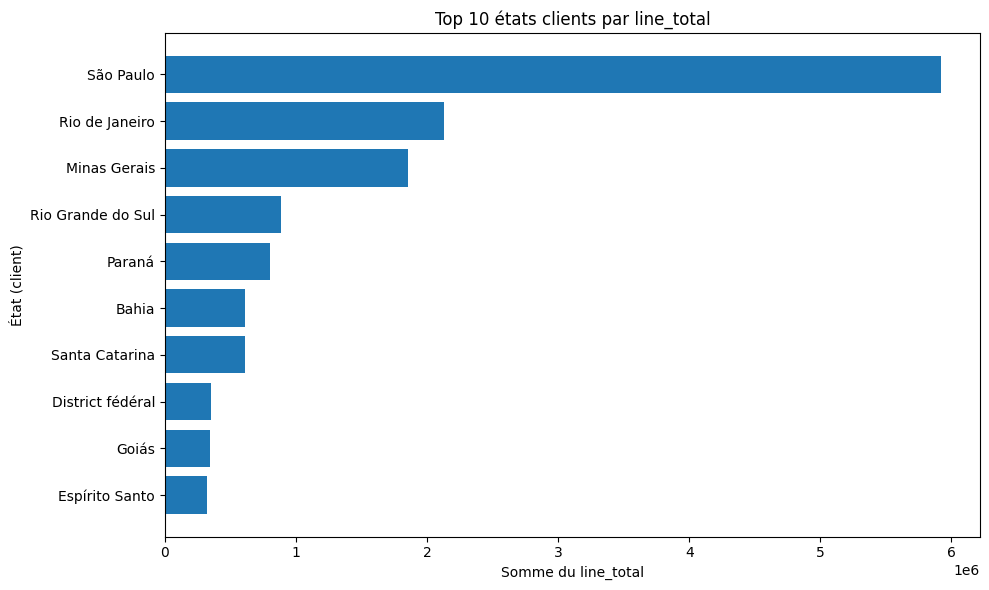

In [41]:
# 6) Répartition du line_total par macro-région et top états clients

# Préparation dimension client + macro-régions
cust_dim = customers[["customer_id", "state", "name_state"]].copy()

region_map = {
    "SP": "Sudeste", "RJ": "Sudeste", "MG": "Sudeste", "ES": "Sudeste",
    "RS": "Sul", "SC": "Sul", "PR": "Sul",
    "BA": "Nordeste", "PE": "Nordeste", "CE": "Nordeste", "RN": "Nordeste",
    "PB": "Nordeste", "AL": "Nordeste", "SE": "Nordeste", "PI": "Nordeste",
    "MA": "Nordeste",
    "DF": "Centro-Oeste", "GO": "Centro-Oeste", "MT": "Centro-Oeste", "MS": "Centro-Oeste",
    "AM": "Norte", "PA": "Norte", "RO": "Norte", "RR": "Norte",
    "AP": "Norte", "TO": "Norte", "AC": "Norte"
}

cust_dim["macro_region"] = cust_dim["state"].map(region_map)

# Jointure avec la table de faits
f_achats_cust = F_ACHATS.merge(cust_dim, on="customer_id", how="left")

# On enlève les lignes sans état ou sans macro-région
f_achats_cust = f_achats_cust.dropna(subset=["state", "macro_region"])

# Agrégation par macro-région
region_totals = (
    f_achats_cust
    .groupby("macro_region", as_index=False)
    .agg(line_total_sum=("line_total", "sum"))
    .sort_values("line_total_sum", ascending=False)
)

# Agrégation par état (pour voir les principaux états dans chaque région)
state_totals = (
    f_achats_cust
    .groupby(["macro_region", "name_state"], as_index=False)
    .agg(line_total_sum=("line_total", "sum"))
)

print("== 6a) line_total par macro-région client ==")
display(region_totals)

print("== 6b) Top 10 états clients par line_total ==")
top_states = state_totals.sort_values("line_total_sum", ascending=False).head(10)
display(top_states)

# Affichage 6a : macro-régions
plt.figure(figsize=(8, 4))
plt.bar(region_totals["macro_region"], region_totals["line_total_sum"])
plt.title("Répartition du line_total par macro-région client")
plt.xlabel("Macro-région")
plt.ylabel("Somme du line_total")
plt.tight_layout()
plt.show()

# Affichage 6b : top 10 états
plt.figure(figsize=(10, 6))
plt.barh(top_states["name_state"], top_states["line_total_sum"])
plt.title("Top 10 états clients par line_total")
plt.xlabel("Somme du line_total")
plt.ylabel("État (client)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Ces graphiques confirment que la demande est très concentrée géographiquement, avec un énorme poids du Sudeste,
# qui représente à lui seul plus de la moitié du line_total. Les régions Sul et Nordeste suivent loin derrière,
# tandis que Centro-Oeste et surtout Norte restent marginales en volume. Quand on regarde le détail par état,
# São Paulo domine largement, devant Rio de Janeiro et Minas Gerais, qui sont aussi de grands pôles économiques.
# Les autres états du top 10 appartiennent majoritairement aux régions Sud et Nordeste, ce qui renforce l’idée
# que la croissance observée se fait surtout dans les zones urbaines et les régions les plus développées.
# En combinant cette lecture avec les analyses précédentes, on voit bien que le line_total se concentre à la fois
# sur quelques catégories de produits et sur quelques états clés, ce qui va clairement dans le sens de notre hypothèse.


== 7) Pivot line_total (Macro-région x Catégorie TOP) ==
category_name       auto  bed_bath_table  computers_accessories  cool_stuff  \
macro_region                                                                  
Centro-Oeste    53845.81        63782.93               66992.59    55265.81   
Nordeste       101850.59        79530.42              119030.17    93254.24   
Norte           18002.63        11751.05               29917.04    17694.19   
Sudeste        414863.50       921076.09              685973.34   426574.58   
Sul             96821.79       165541.23              157359.26   126541.13   

category_name  furniture_decor  garden_tools  health_beauty  housewares  \
macro_region                                                              
Centro-Oeste          46684.69      44923.03       98513.81    52130.30   
Nordeste              85204.22      71512.35      236942.00    55356.97   
Norte                 20190.38      13579.22       49867.09    10644.92   
Sudeste       

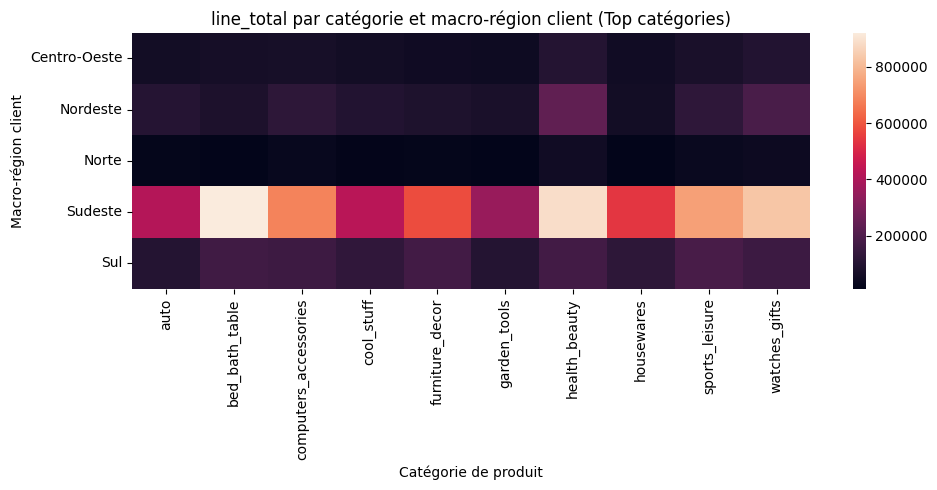

In [42]:
# 7) line_total par catégorie de produit et macro-région client (Top catégories)

# Préparation
# On repart de f_achats_prod (F_ACHATS + catégorie) et de cust_dim (avec macro_region)
f_achats_full = f_achats_prod.merge(
    cust_dim[["customer_id", "macro_region"]],
    on="customer_id",
    how="left"
)

# On enlève les lignes sans catégorie ou sans macro-région
f_achats_full = f_achats_full.dropna(subset=["category_name", "macro_region"])

# On se limite aux top catégories déjà identifiées
f_achats_full_top = f_achats_full[f_achats_full["category_name"].isin(top_cat_list)].copy()

cat_region = (
    f_achats_full_top
    .groupby(["macro_region", "category_name"], as_index=False)
    .agg(line_total_sum=("line_total", "sum"))
)

pivot_cat_region = (
    cat_region
    .pivot(index="macro_region", columns="category_name", values="line_total_sum")
    .fillna(0)
)

print("== 7) Pivot line_total (Macro-région x Catégorie TOP) ==")
print(pivot_cat_region)

# Affichage
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_cat_region, annot=False)
plt.title("line_total par catégorie et macro-région client (Top catégories)")
plt.xlabel("Catégorie de produit")
plt.ylabel("Macro-région client")
plt.tight_layout()
plt.show()


In [ ]:
# On voit très clairement que la macro-région Sudeste domine toutes les autres pour l’ensemble des catégories.
# Elle cumule à elle seule des volumes bien supérieurs, notamment sur health_beauty, watches_gifts et bed_bath_table.
# Les régions Sul et Nordeste arrivent ensuite, mais avec des niveaux nettement inférieurs, ce qui montre une forte concentration géographique des achats.
# Le Norte et le Centro-Oeste restent très marginaux, quel que soit le segment, ce qui confirme un effet “marché principal” centré sur les zones les plus urbaines et développées.
# Les catégories déjà identifiées comme dominantes au niveau national restent également les plus fortes dans le Sudeste, ce qui renforce l’idée d’une double concentration : produits + géographie.
# Le poids très élevé de health_beauty et watches_gifts dans le Sudeste confirme que les pics observés précédemment s’appuient sur ces segments spécifiques dans cette région clé.
# Cette lecture va dans le sens de notre hypothèse : une part importante du line_total provient de quelques catégories, achetées principalement dans une seule macro-région dominante.


== 8A) Pivot quotidien par macro-région (aires empilées) ==


macro_region,Centro-Oeste,Nordeste,Norte,Sudeste,Sul
date,,,,,
2017-11-01,2541.82,3524.11,1081.93,12339.86,2579.27
2017-11-02,1289.87,3488.01,411.88,16998.44,1894.74
2017-11-03,3319.80,3115.75,451.95,16024.29,3124.36
2017-11-04,1545.50,2166.06,1639.33,13172.52,3771.40
2017-11-05,1022.11,3846.69,705.33,12212.14,3115.68


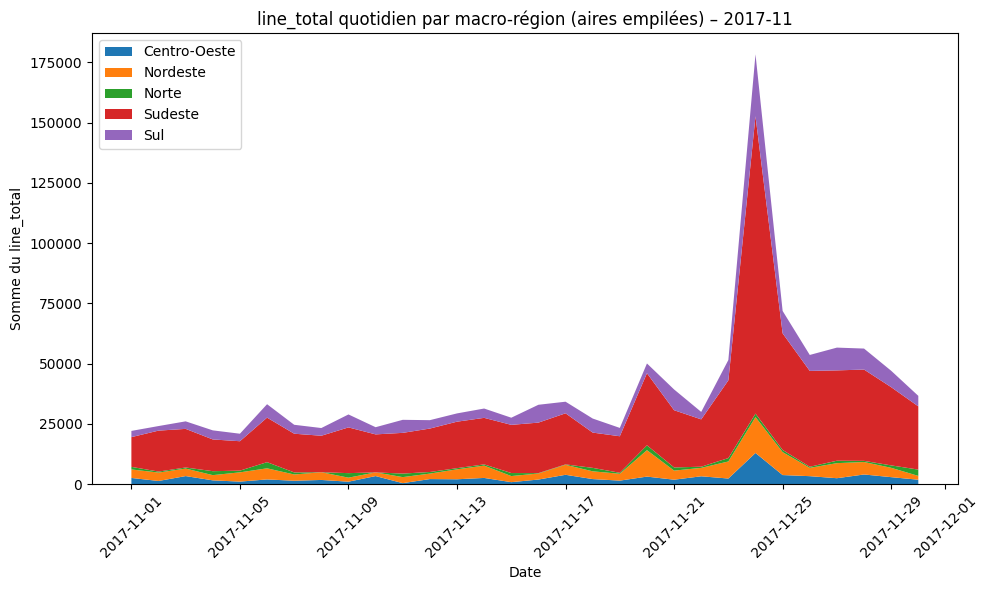

In [46]:
# 8 line_total quotidien – aires empilées par macro-région

# Préparation
pivot_region_daily = (
    daily_region_peak
    .pivot(index="date", columns="macro_region", values="line_total_sum")
    .fillna(0)
    .sort_index()
)

print("== 8A) Pivot quotidien par macro-région (aires empilées) ==")
display(pivot_region_daily.head())

# Affichage
plt.figure(figsize=(10, 6))
dates = pivot_region_daily.index
values = [pivot_region_daily[col].values for col in pivot_region_daily.columns]

plt.stackplot(dates, *values, labels=pivot_region_daily.columns)
plt.title(f"line_total quotidien par macro-région (aires empilées) – {peak_year}-{str(peak_month).zfill(2)}")
plt.xlabel("Date")
plt.ylabel("Somme du line_total")
plt.xticks(rotation=45)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# Ce graphique montre l’évolution quotidienne du line_total pendant le mois de pic, ventilé par macro-région.  
# On voit que la quasi-totalité du volume est portée par le Sudeste, qui domine tous les jours et explose lors du pic de fin novembre.  
# Les régions Sul et Nordeste contribuent un peu aux variations, mais restent très loin derrière, surtout lors du jour de très forte pointe.  
# Centro-Oeste et Norte restent marginaux sur toute la période : même quand le volume global monte, leur contribution reste faible.  
# Le pic massif observé fin novembre est donc surtout un phénomène “Sudeste”, ce qui suggère un événement promotionnel concentré sur cette zone.  
# Cette lecture renforce l’hypothèse : les périodes de pic ne profitent pas à toutes les régions de la même façon, mais surtout à une macro-région clé, plus exposée aux enjeux logistiques.  


== 9) Top 10 segments (macro-région x catégorie) sur le mois de pic ==


,macro_region,category_name,line_total_sum,segment
129,Sudeste,bed_bath_table,81504.15,Sudeste - bed_bath_table
187,Sudeste,watches_gifts,69142.03,Sudeste - watches_gifts
163,Sudeste,health_beauty,55648.11,Sudeste - health_beauty
159,Sudeste,furniture_decor,52392.11,Sudeste - furniture_decor
186,Sudeste,toys,51071.08,Sudeste - toys
182,Sudeste,sports_leisure,50502.13,Sudeste - sports_leisure
137,Sudeste,computers_accessories,48548.47,Sudeste - computers_accessories
142,Sudeste,cool_stuff,38313.64,Sudeste - cool_stuff
162,Sudeste,garden_tools,35281.84,Sudeste - garden_tools
169,Sudeste,housewares,32402.58,Sudeste - housewares


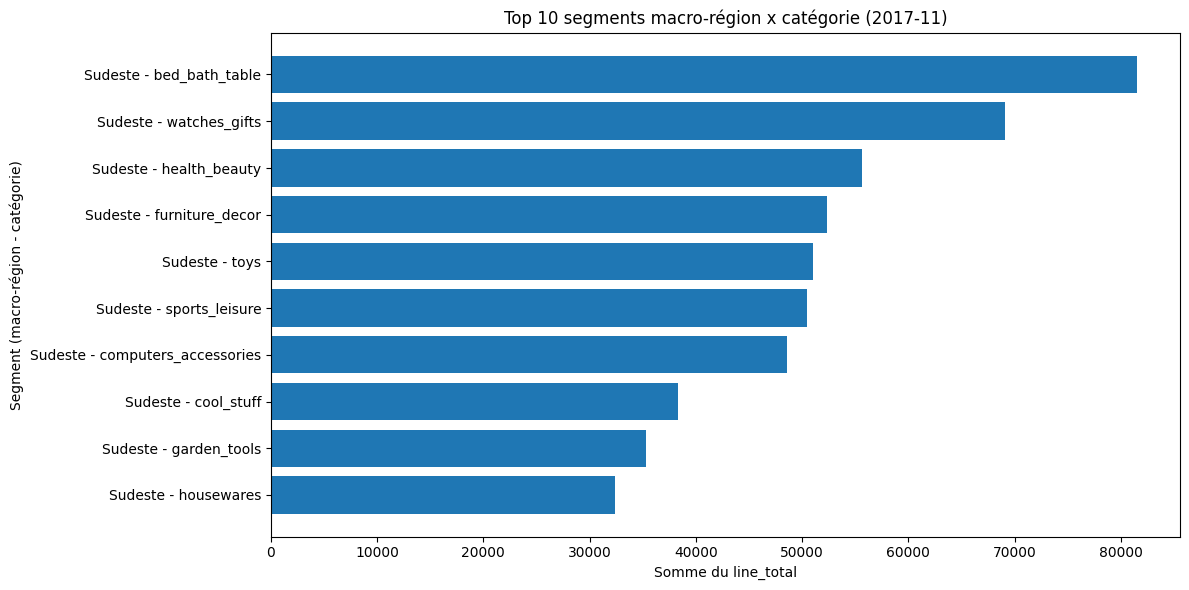

In [45]:
# 9) Segments clés (catégorie x macro-région) sur le mois de pic

# Préparation
# On repart du mois de pic et on croise produit + macro-région
f_peak_prod = f_peak.merge(prod_dim, on="product_id", how="left")
f_peak_prod = f_peak_prod.dropna(subset=["category_name"])

f_peak_prod_cust = f_peak_prod.merge(
    cust_dim[["customer_id", "macro_region"]],
    on="customer_id",
    how="left"
)

# On garde les lignes avec macro-région
f_peak_prod_cust = f_peak_prod_cust.dropna(subset=["macro_region"])

seg_peak = (
    f_peak_prod_cust
    .groupby(["macro_region", "category_name"], as_index=False)
    .agg(line_total_sum=("line_total", "sum"))
)

# Construction d'un libellé de segment (macro-région - catégorie)
seg_peak["segment"] = seg_peak["macro_region"] + " - " + seg_peak["category_name"]

# Top 10 segments sur le mois de pic
top_segments = seg_peak.sort_values("line_total_sum", ascending=False).head(10)

print("== 9) Top 10 segments (macro-région x catégorie) sur le mois de pic ==")
display(top_segments)

# Affichage
plt.figure(figsize=(12, 6))
plt.barh(top_segments["segment"], top_segments["line_total_sum"])
plt.title(f"Top 10 segments macro-région x catégorie ({peak_year}-{str(peak_month).zfill(2)})")
plt.xlabel("Somme du line_total")
plt.ylabel("Segment (macro-région - catégorie)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Ce graphique montre que, pendant le mois de pic, les 10 plus gros segments
# combinent tous la macro-région Sudeste avec quelques catégories dominantes.
# On retrouve principalement bed_bath_table, watches_gifts, health_beauty
# et d’autres catégories déjà identifiées comme moteurs du chiffre d’affaires.
# Cela confirme une double concentration : à la fois géographique (quasi tout
# se joue dans le Sudeste) et produit (quelques familles seulement tirent les ventes).
# Ces segments sont ceux où les paniers sont les plus élevés, avec parfois un
# poids logistique important, ce qui en fait des zones critiques en cas de tension
# sur la livraison, exactement dans le sens de notre hypothèse de départ.
